In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)
matplotlib.rc('axes',labelsize=25) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

In [3]:
def violinplot(mls, kind, bands, cnc, crc, save=''):
    music1 = read_music(mls[0], kind, bands[0], cnc, crc)
    music2 = read_music(mls[1], kind, bands[1], cnc, crc)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    sns.violinplot(music1.tempscales.astype(int).values, music1.chains.values, hue=music1.ncrc.values,
                        palette='Set2',split=True, inner='quartile', ax = ax1)

    sns.violinplot(music2.tempscales.astype(int).values, music2.chains.values, hue=music2.ncrc.values,
                    palette='Set2',split=True, inner='quartile', ax = ax2)
    ax1.grid()
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  
    ax1.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)', ylabel='Position of RC in '+bands[0]+' band (mag)')
    ax1.set_title(bands[0]+' band',fontsize=25)
    ax2.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)', ylabel=r'Position of RC in $\emph{Gaia}$ G band (mag)')
    ax2.set_title(r'$\emph{Gaia}$ G band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    fig.tight_layout()
    
    if save is not '':
        plt.savefig(save)
    plt.show()
    
def read_music(ml, kind, band, cnc, crc):
    chains = np.array([])
    tempscales = np.array([])
    ncrc = np.array([])

    for ts in np.arange(-50.,60.,10.):
        temp = str(ts)
        #Add NC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+cnc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['No Correction']*len(chain))

        #Add RC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+crc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['Clump Corrected']*len(chain))

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['ncrc'] = ncrc
    return music

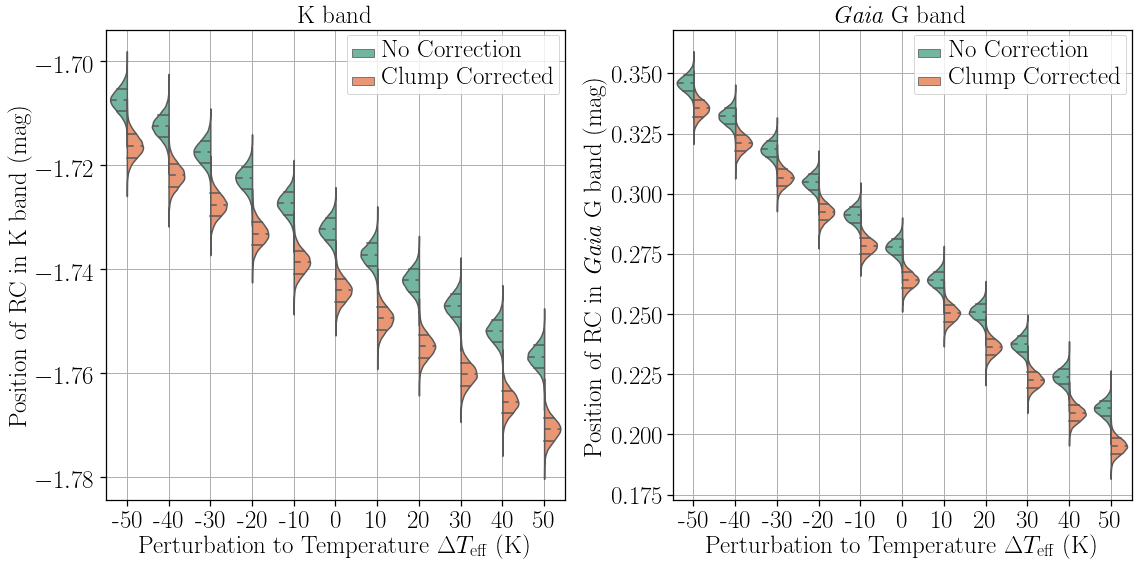

In [4]:
mls = ['lt_K_tempscale', 'pre-4chainruns/lt_GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/yu_posteriors.pdf')

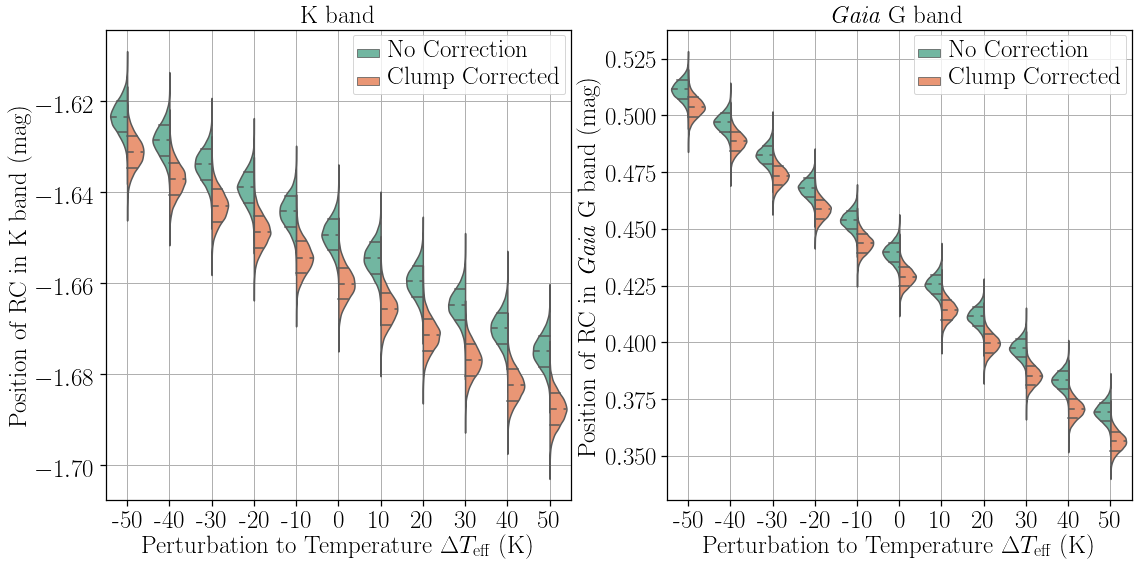

In [7]:
mls = ['APOKASC_K_tempscale', 'APOKASC_GAIA_tempscale']
# mls = ['APOFULL_K_tempscale', 'APOFULL_GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/apokasc2_posteriors.pdf')